In [11]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re

In [12]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [ ]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    plot_prediction_losses,
    test_model_with_varying_observed_points,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    )

In [14]:
save_dir_path = "./save_directory_3" 


In [6]:
with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']

train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']

with open("df_high_energy_revised.pkl", "rb") as f:
    df_high_energy_revised = pickle.load(f)

val_df_high_energy_revised = df_high_energy_revised['val_df_high_energy_revised']
val_id_df_high_energy_revised = df_high_energy_revised['val_id_df_high_energy_revised']

test_df_high_energy_revised = df_high_energy_revised['test_df_high_energy_revised']
test_id_df_high_energy_revised = df_high_energy_revised['test_id_df_high_energy_revised']

In [7]:
train_id_df_added = add_phi_A_columns(train_id_df)
val_id_df_added = add_phi_A_columns(val_id_df)
val_id_df_high_energy_revised_added = add_phi_A_columns(val_id_df_high_energy_revised)


📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 297 with the value: 1.997200, the losses of the last 5 epochs are: [1.9995278716087341, 1.9989134073257446, 1.998904546101888, 1.9984555840492249, 1.9996634125709534]
  Lowest loss of metric 'train_variance_loss_' recorded in epoch 299 with the value: 118.600962, the losses of the last 5 epochs are: [119.26854916774866, 119.24941091826467, 119.29730426903927, 119.1108532818881, 119.3053690592448]
  Lowest loss of metric 'train_prediction_loss_' recorded in epoch 318 with the value: 2.076465, the losses of the last 5 epochs are: [2.0880126483512647, 2.082476109266281, 2.0856626015720945, 2.092180238528685, 2.07969853552905]
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 328 with the value: 118.970012, the losses of the last 5 epochs are: [119.04987519129038, 119.0845060416447, 119.10125967610718, 119.0571238785845, 119.09089766278036]
  Lowest loss of metric 'val_prediction_

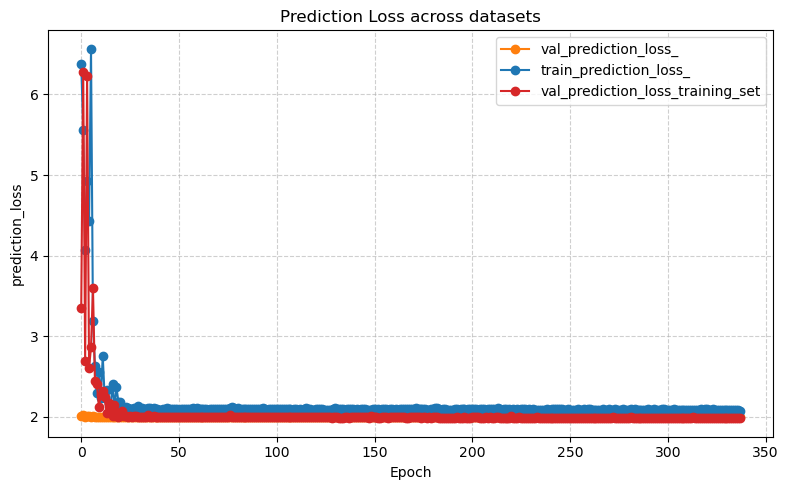

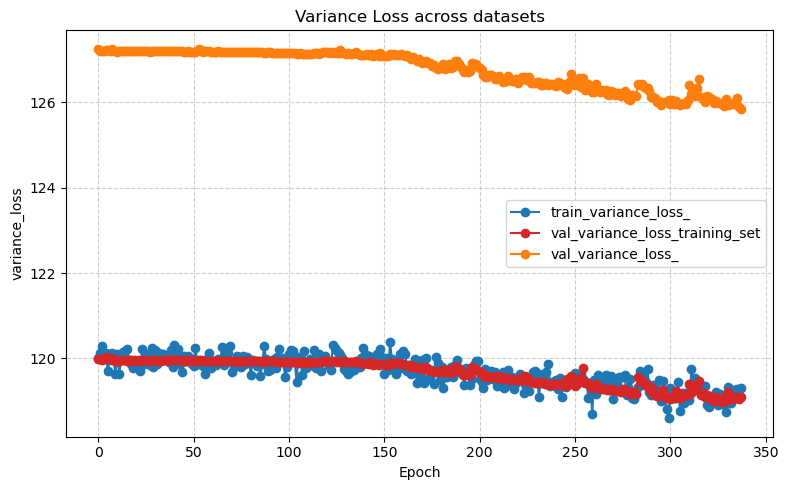

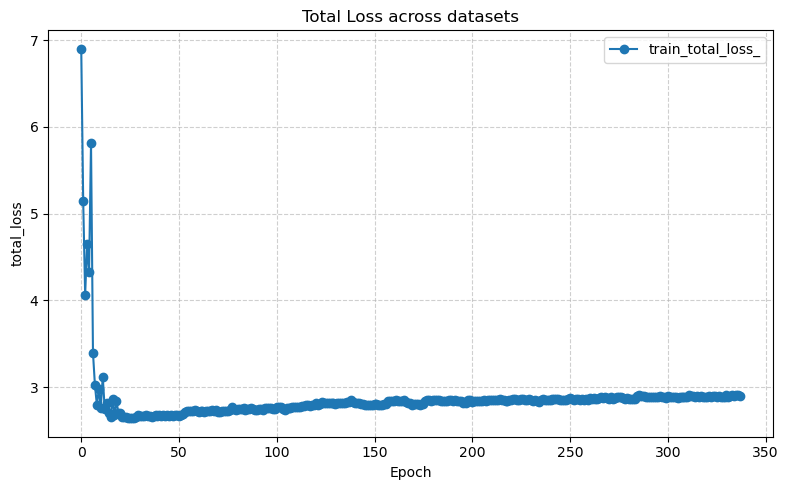

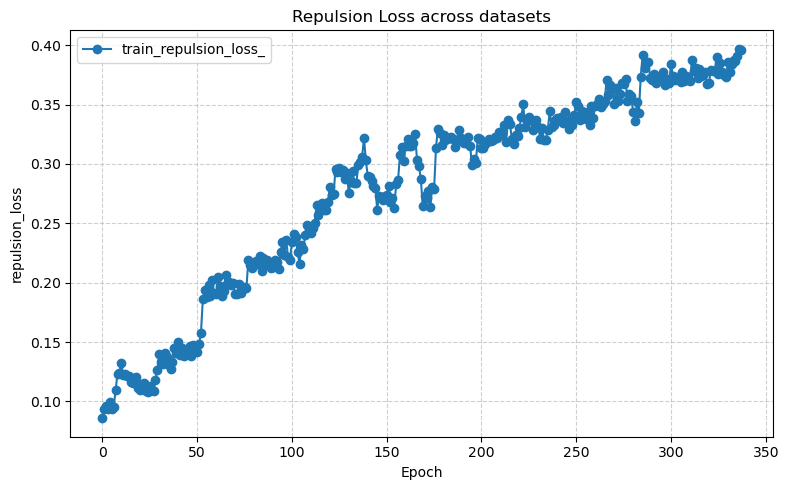

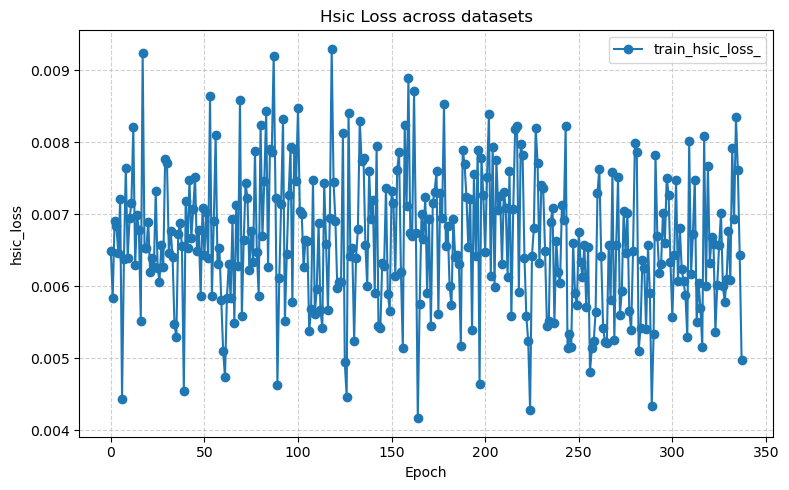

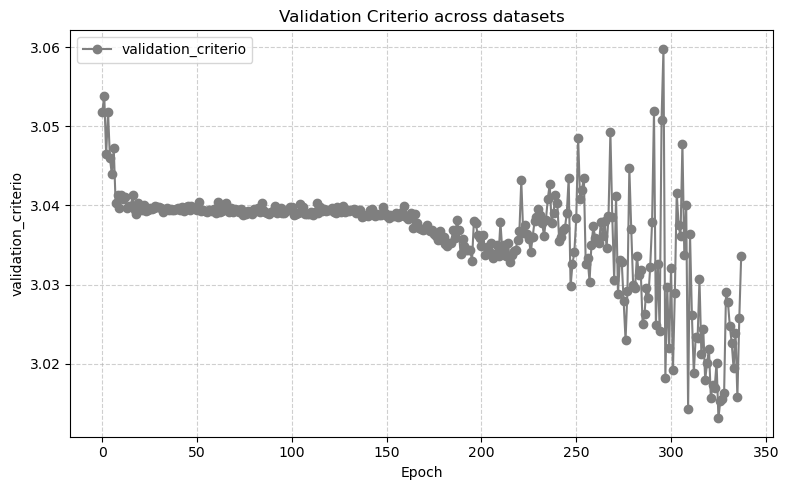

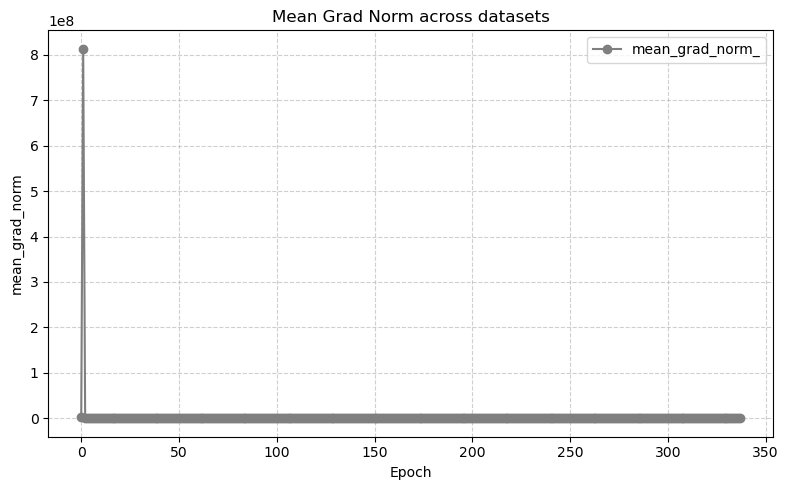


✅ Visualization complete.


In [179]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "train_variance_loss_", "train_prediction_loss_", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_"],
plot_on_same_graph=True,
verbose=True
)




📊 Processing directory: val_trajectories_data

For the epoch_25 in val_trajectories_data the values are:
92: X_mean = 0.5042 ± 9.6133, U_mean = -0.5349 ± 9.6043 and A=13.564677634903196, phi=-2.7802771843251053
64: X_mean = 0.5162 ± 8.0145, U_mean = -0.5203 ± 8.0133 and A=11.313750136394223, phi=-2.8600808883112765
6: X_mean = 0.5600 ± 2.4604, U_mean = -0.4112 ± 2.4513 and A=3.4643759649388923, phi=0.5272390069263062

📊 Processing directory: val_train_set_trajectories_data

For the epoch_25 in val_train_set_trajectories_data the values are:
2: X_mean = 0.5356 ± 1.4295, U_mean = -0.4281 ± 1.4039 and A=2.0004916751010886, phi=-1.322539930867642
120: X_mean = 0.5078 ± 10.9796, U_mean = -0.3127 ± 10.9763 and A=15.491933918298438, phi=-0.3577443145058989
96: X_mean = 0.5584 ± 9.8148, U_mean = -0.3217 ± 9.8233 and A=13.856421371448707, phi=0.050548714589954684

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_25 in val_high_energy_trajectories_data the values are:
7:

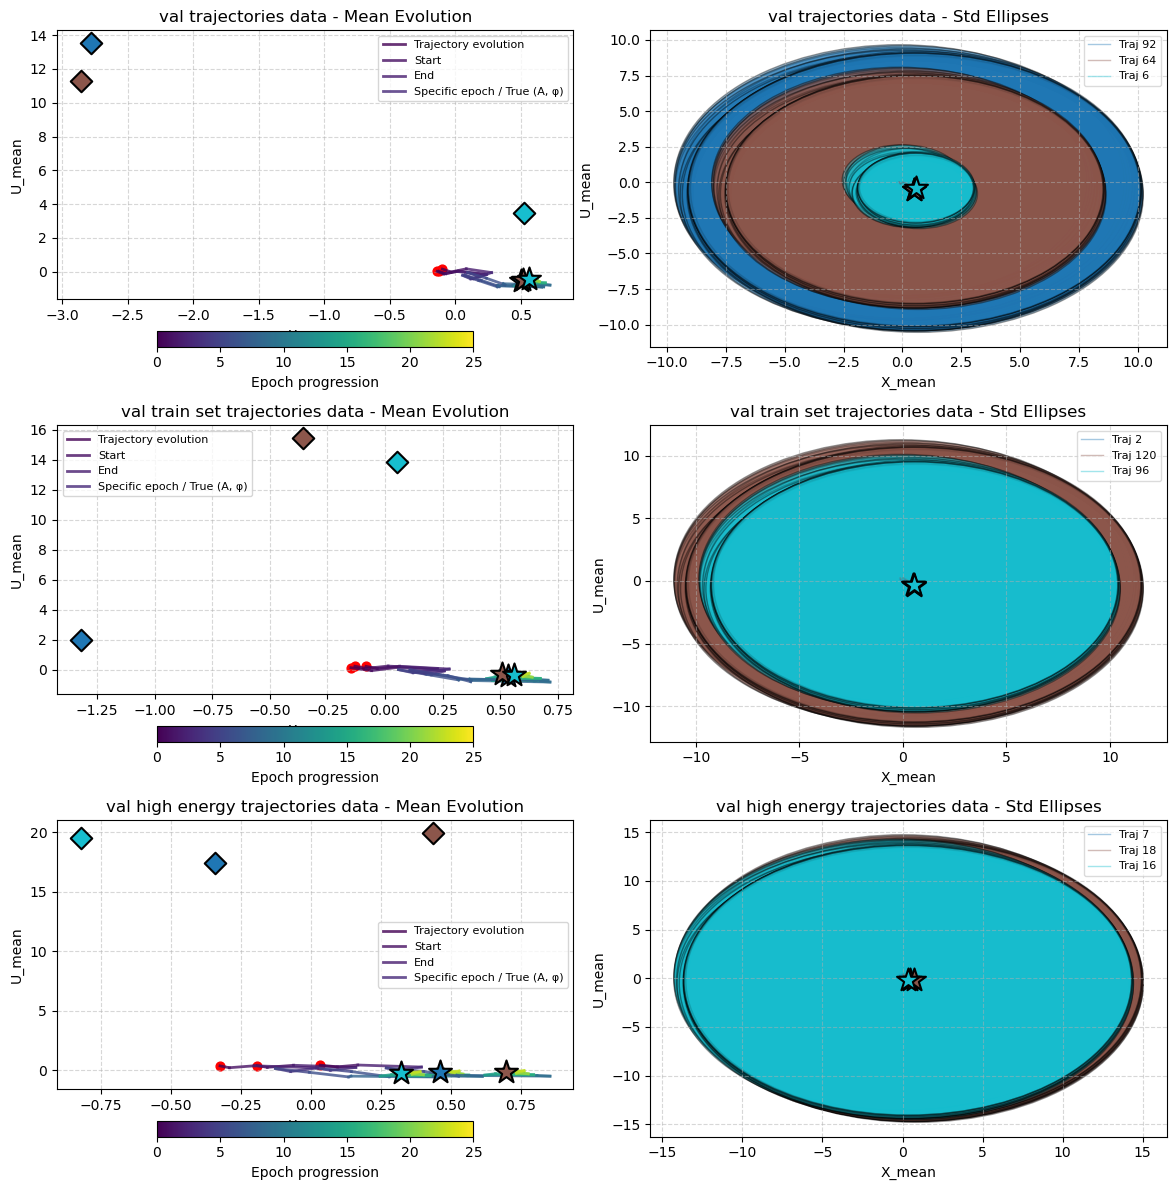


✅ Mean + Std (ellipse) visualization complete.


In [169]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_added,val_id_df_added=val_id_df_added,val_id_df_high_energy_added=val_id_df_high_energy_revised_added)

In [170]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_added,
    val_id_df_added=val_id_df_added,
    val_id_df_high_energy_added=val_id_df_high_energy_revised_added
)

📂 Using data from epoch: epoch_25
✅ Data extraction complete.


In [171]:
np.cov(val_train_differencies_set_df['A'], val_train_differencies_set_df['phi'])

array([[14.40715418,  0.41387528],
       [ 0.41387528,  3.84213375]])

In [172]:
np.cov(val_train_differencies_set_df['X_mean'], val_train_differencies_set_df['U_mean'])

array([[0.00170388, 0.00019527],
       [0.00019527, 0.00641961]])

14.94

In [173]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['A']),
    y=torch.Tensor(val_train_differencies_set_df['phi']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

In [174]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

0.0657

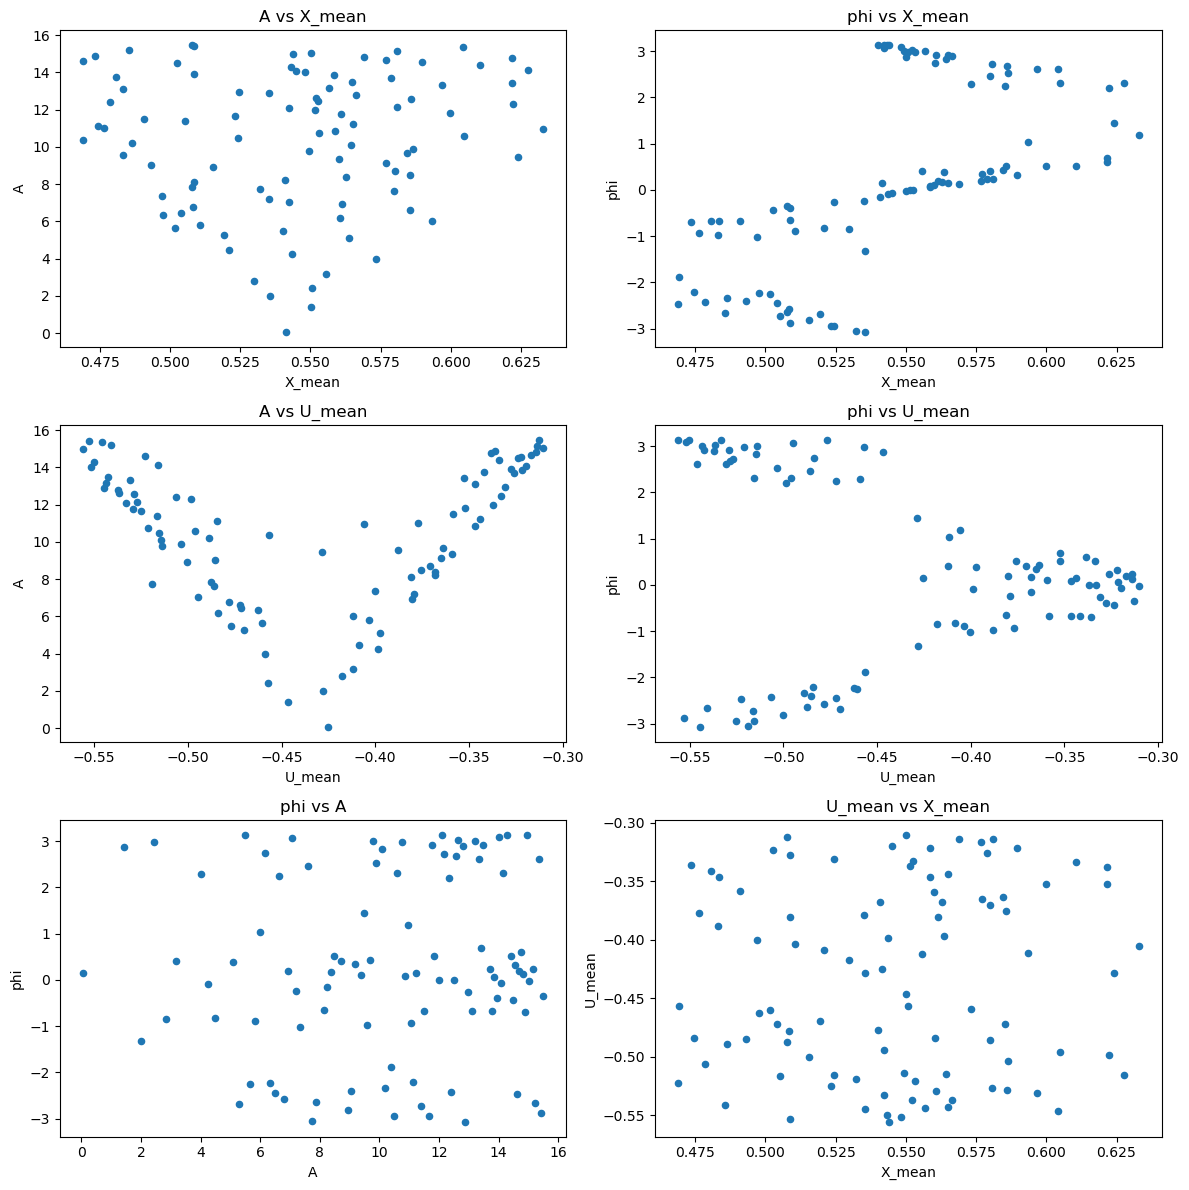

In [175]:
plot_differencies(val_train_differencies_set_df)

📊 Analyzing 105 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


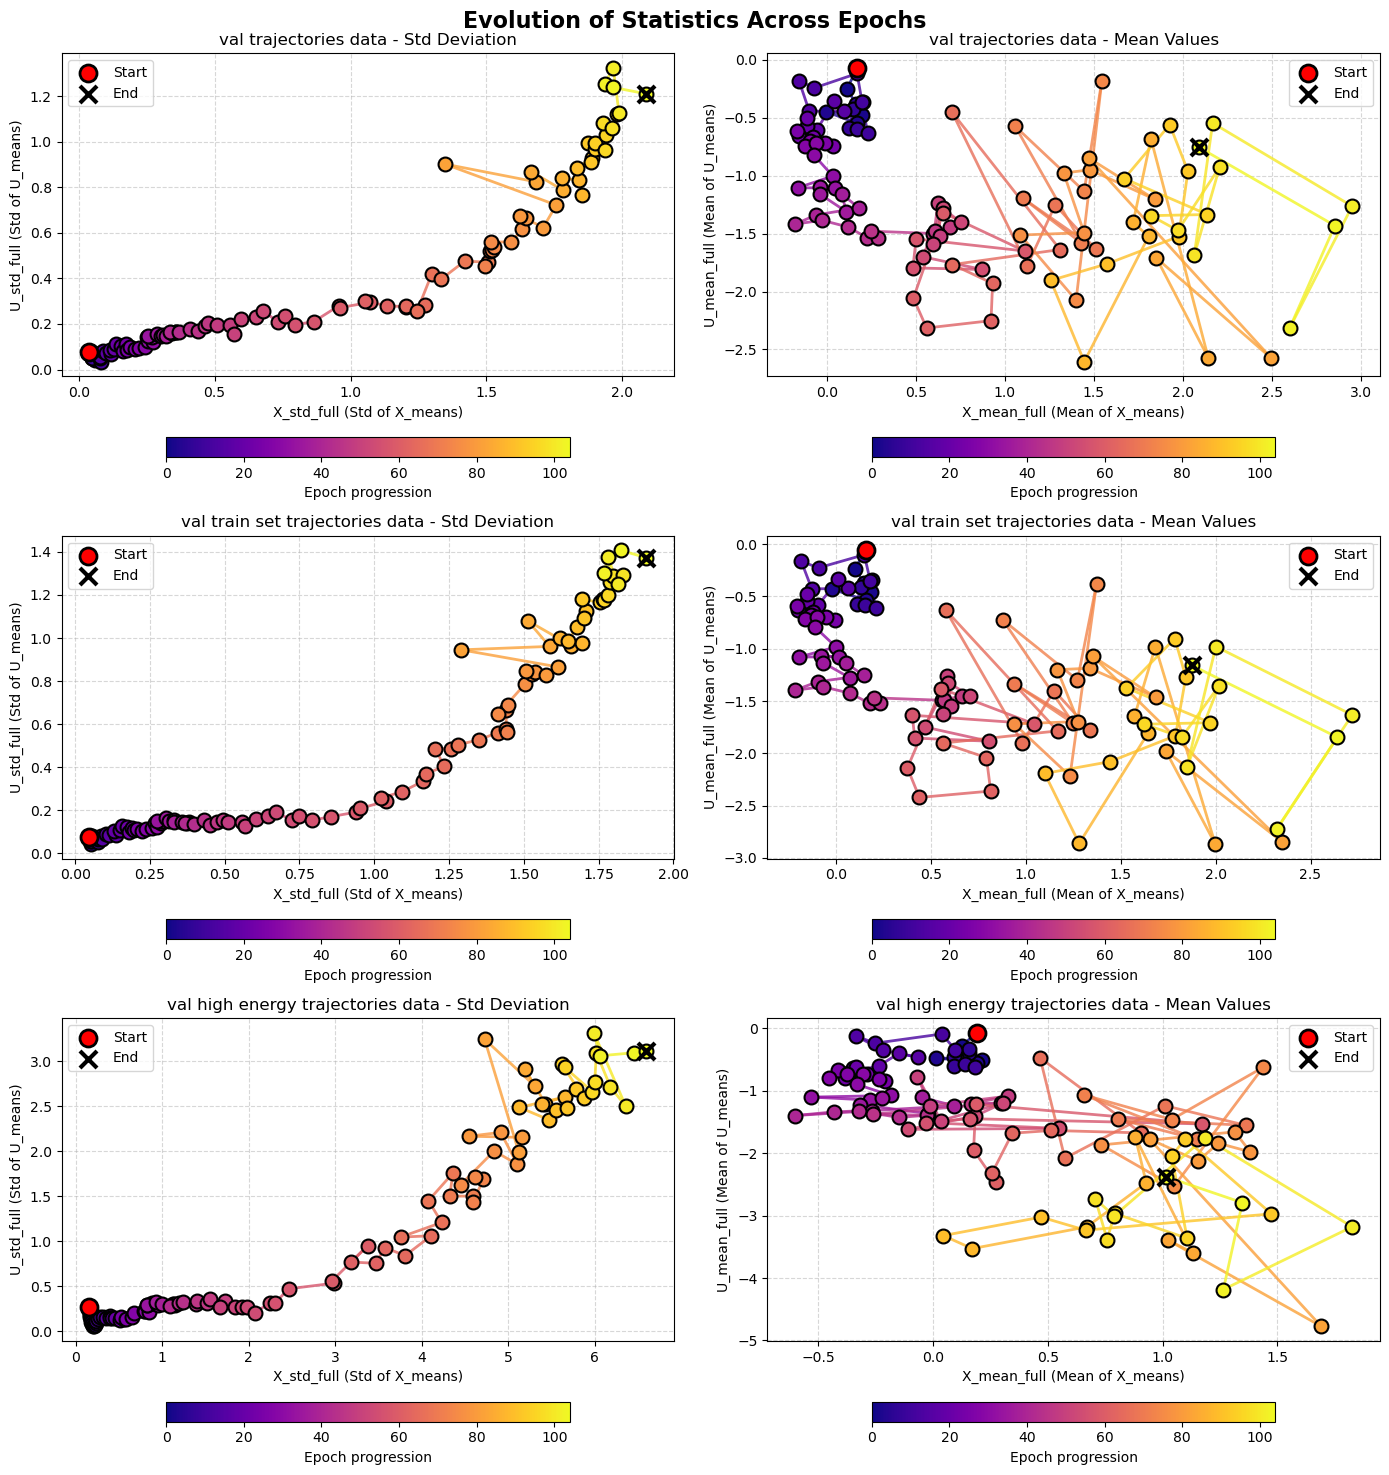

In [35]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [8]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [10, 20, 10],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:4013: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [28]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df, test_df=val_df, trajectory_id=50, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 242 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 6.29e-05
For the inverse network:
✓ All 242 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 5.34e-05


In [8]:
count_parameters(mapping_net)

9500

In [ ]:
result_val_df, mean_prediction_loss_val_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df, test_df=val_df, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0])

np.float64(12.518600500546968)

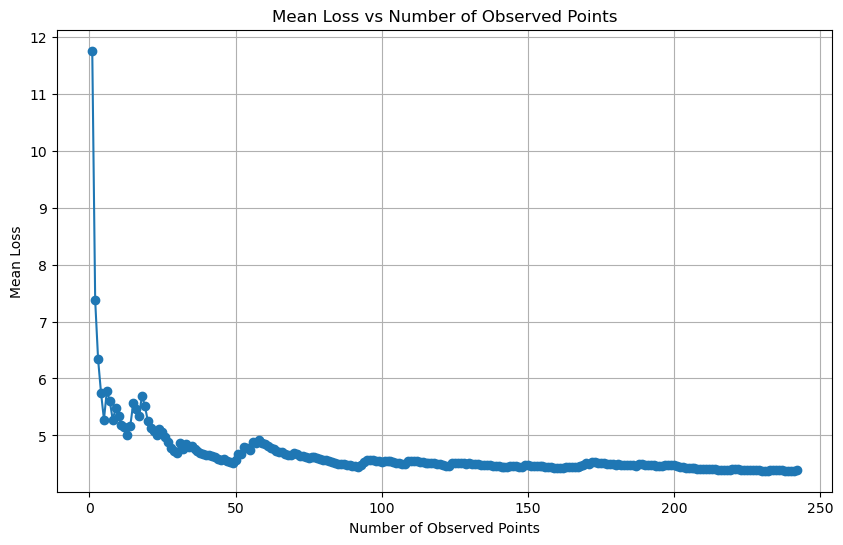

In [ ]:
loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df, test_df=test_df, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

     trajectory_id      energy  prediction_loss  loss_per_sqrt_energy
7                7    7.000942        13.403343              5.065647
12              12   12.000901         6.110855              1.763986
32              32   32.000736        21.628094              3.823299
37              37   37.000694         8.372303              1.376385
39              39   39.000678         8.715674              1.395613
53              53   53.000562         6.714259              0.922270
57              57   57.000529        20.688946              2.740305
67              67   67.000446        20.250467              2.473980
75              75   75.000380        20.209881              2.333630
81              81   81.000331         9.526179              1.058462
88              88   88.000273         6.980634              0.744137
101            101  101.000165        10.753815              1.070044
117            117  117.000033         9.387357              0.867861


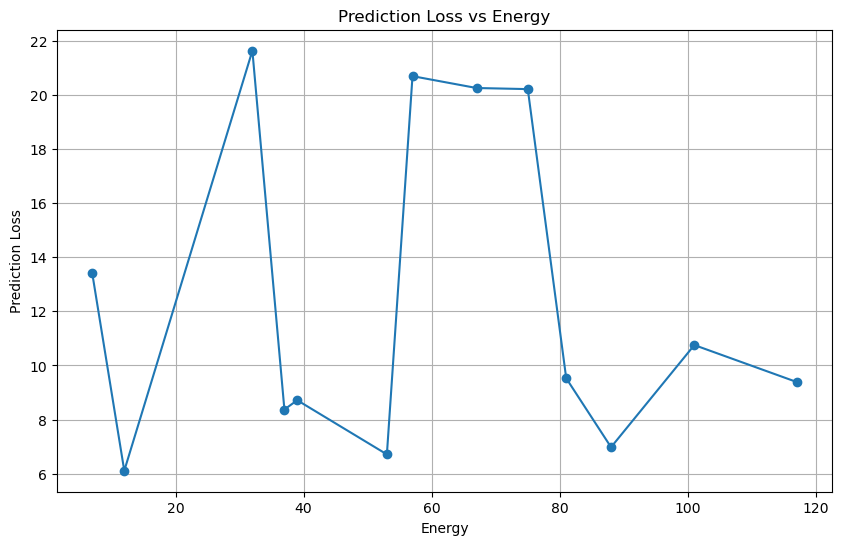

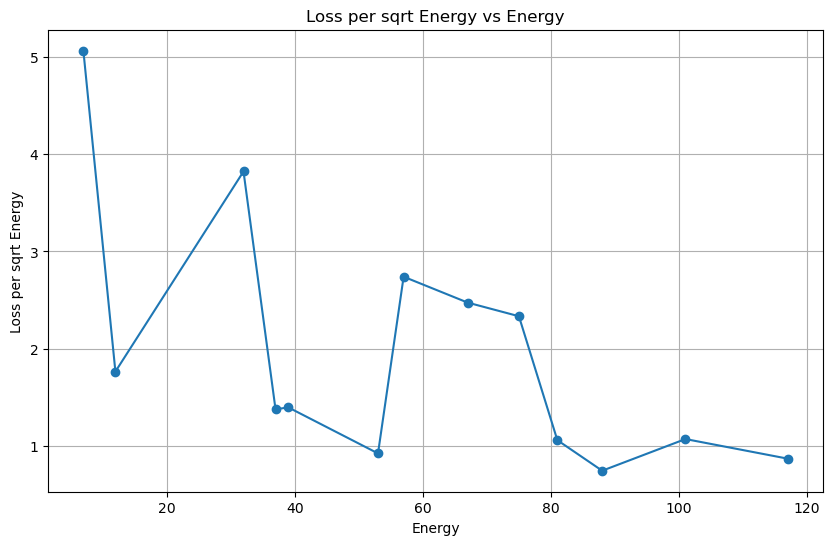

In [ ]:
result_test_df, mean_prediction_loss_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df, test_df=test_df, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0])

Observed time points: [0.]


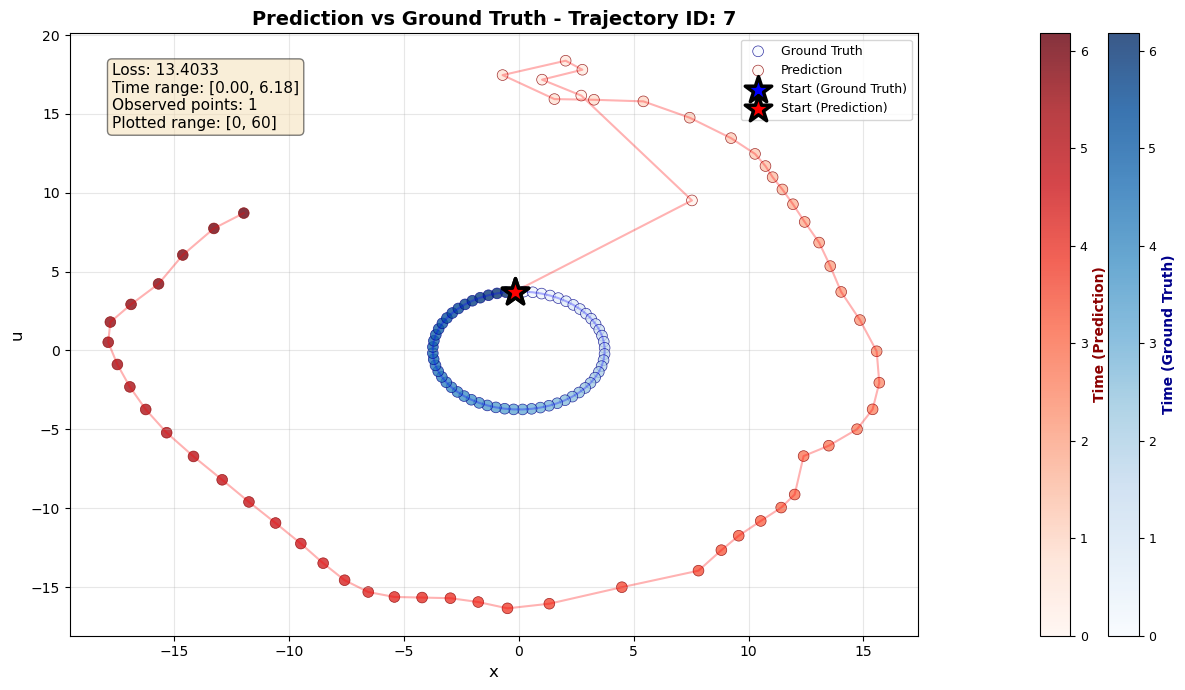

In [9]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df, test_df=test_df, trajectory_id=7, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0], connect_points=True, portion_to_visualize=[0,60])

    trajectory_id      energy  prediction_loss  loss_per_energy
2               2  129.709677        12.069921         0.093053
4               4  138.419355        15.362644         0.110986
5               5  142.774194        26.938372         0.188678
6               6  147.129032         6.531866         0.044395
9               9  160.193548        25.728422         0.160608
10             10  164.548387        36.178822         0.219867
12             12  173.258065        19.007359         0.109705
14             14  181.967742        37.743122         0.207417
15             15  186.322581         7.509525         0.040304
17             17  195.032258        29.427843         0.150887
19             19  203.741935        12.681004         0.062241
20             20  208.096774        57.824913         0.277875
22             22  216.806452        37.959465         0.175085
26             26  234.225806        56.135948         0.239666
28             28  242.935484        38.

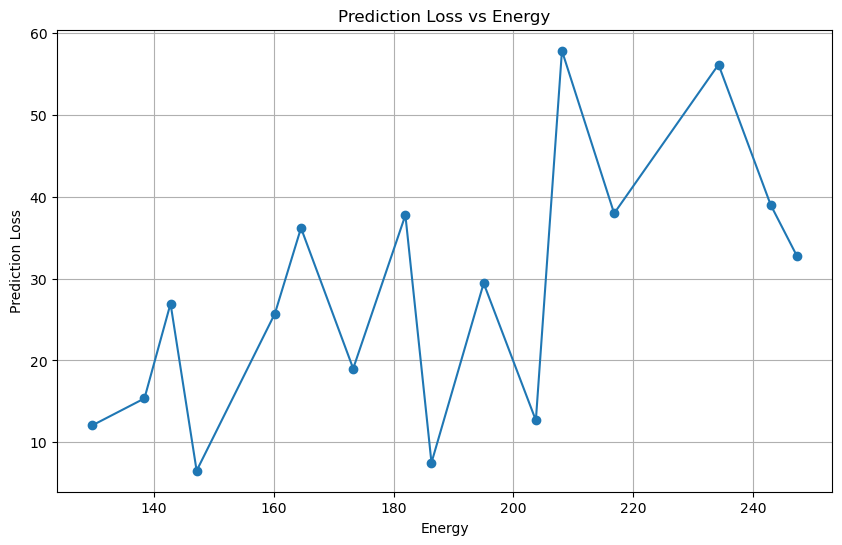

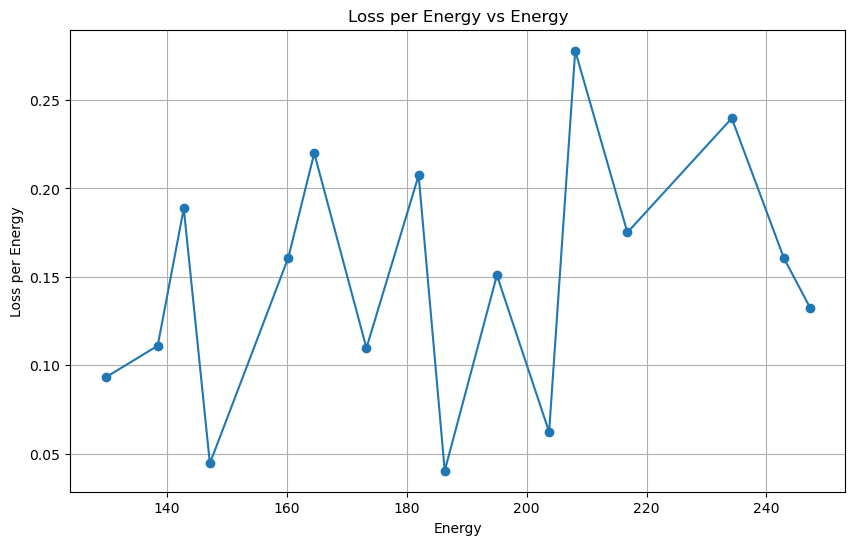

In [ ]:
result_test_high_energy_df, mean_prediction_loss_test_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_revised, test_df=test_df_high_energy_revised, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0])

Observed time points: [0.]


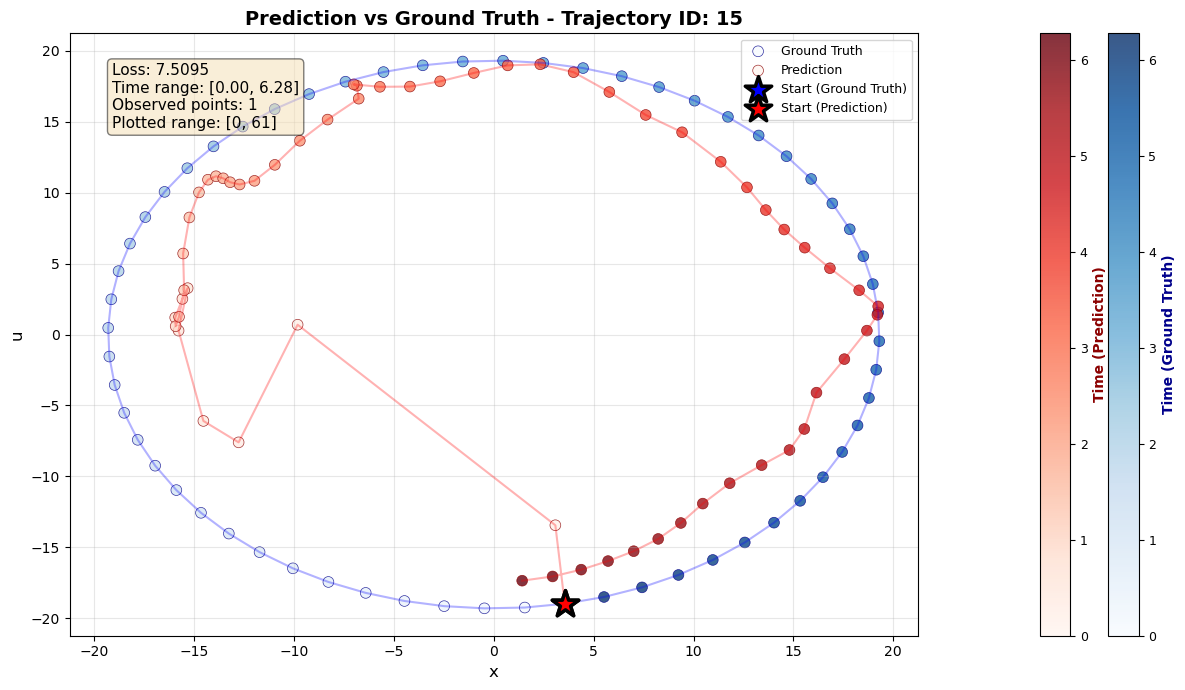

In [17]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_revised, test_df=test_df_high_energy_revised, trajectory_id=15, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0], connect_points=True, portion_to_visualize=[0,61])

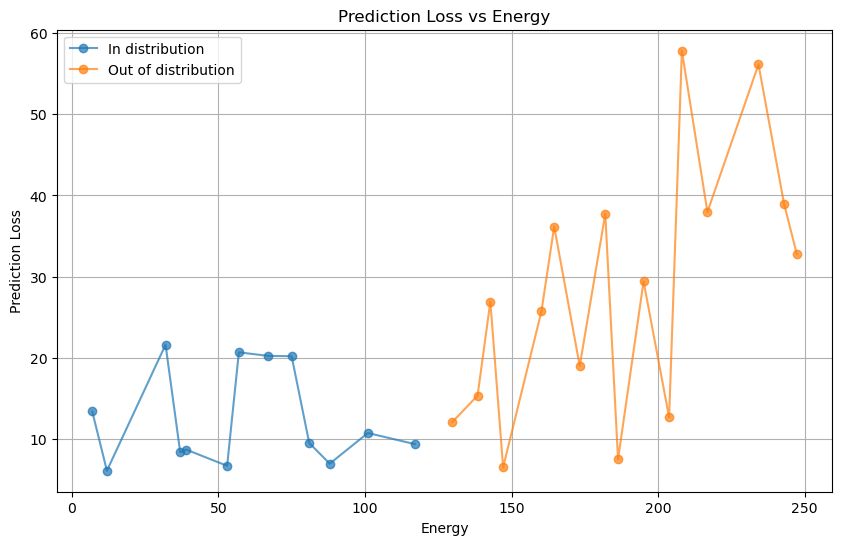

In [12]:
plot_prediction_losses([result_test_df, result_test_high_energy_df])

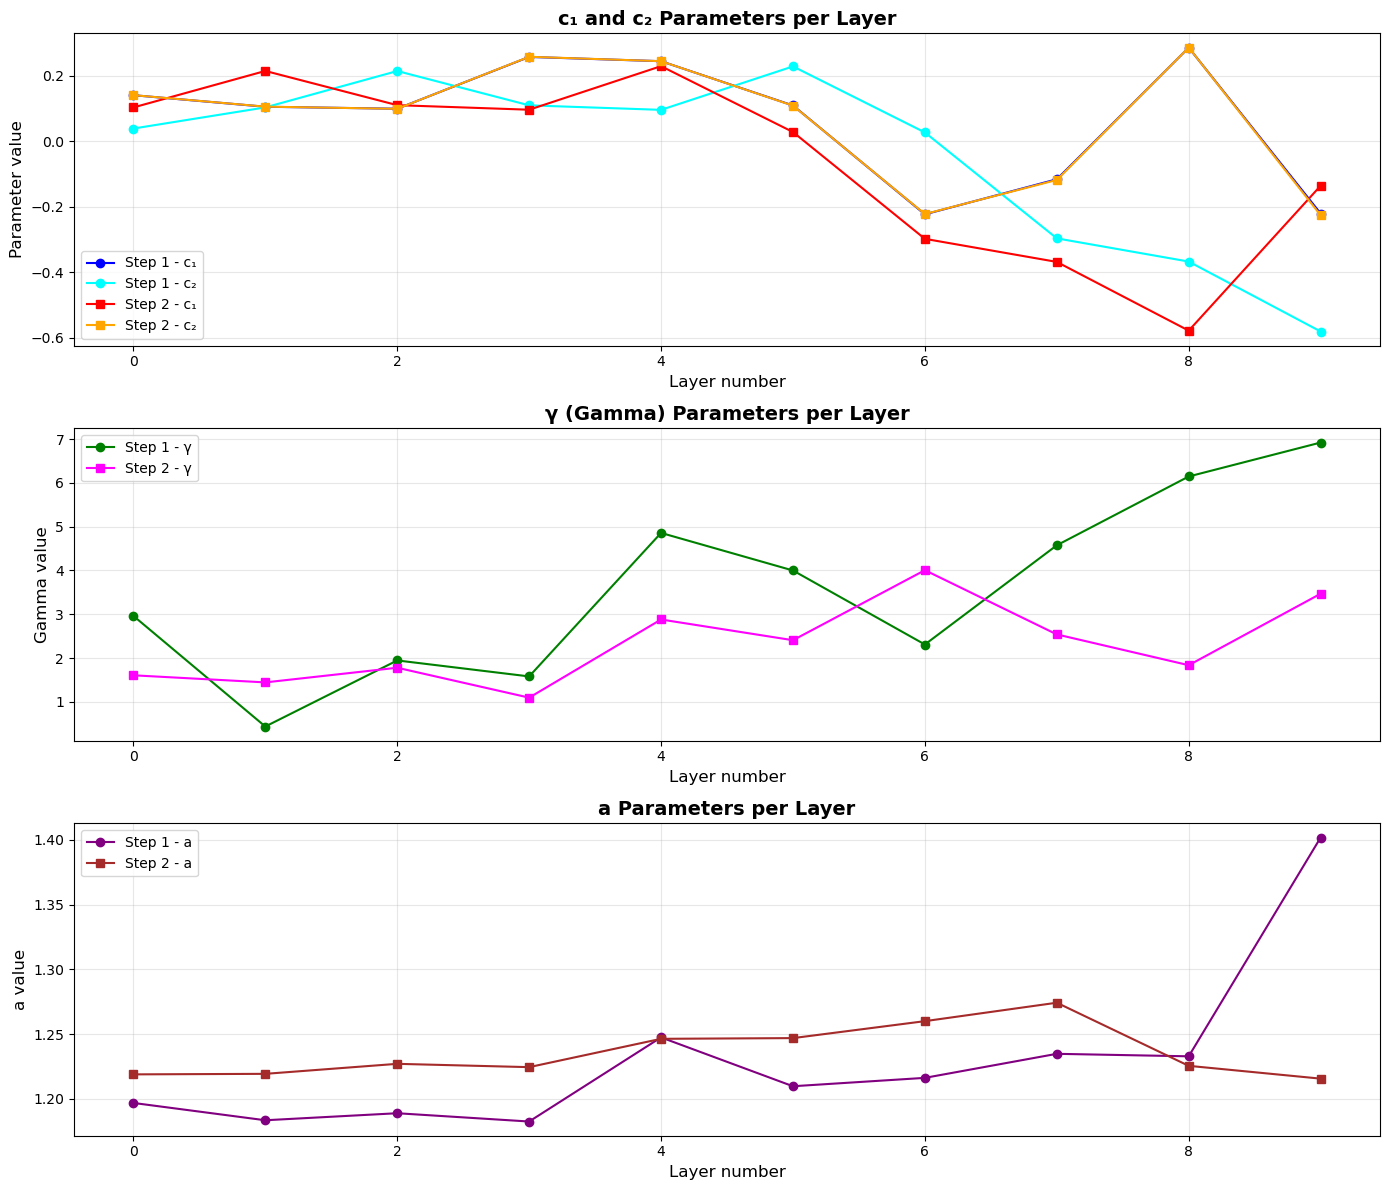

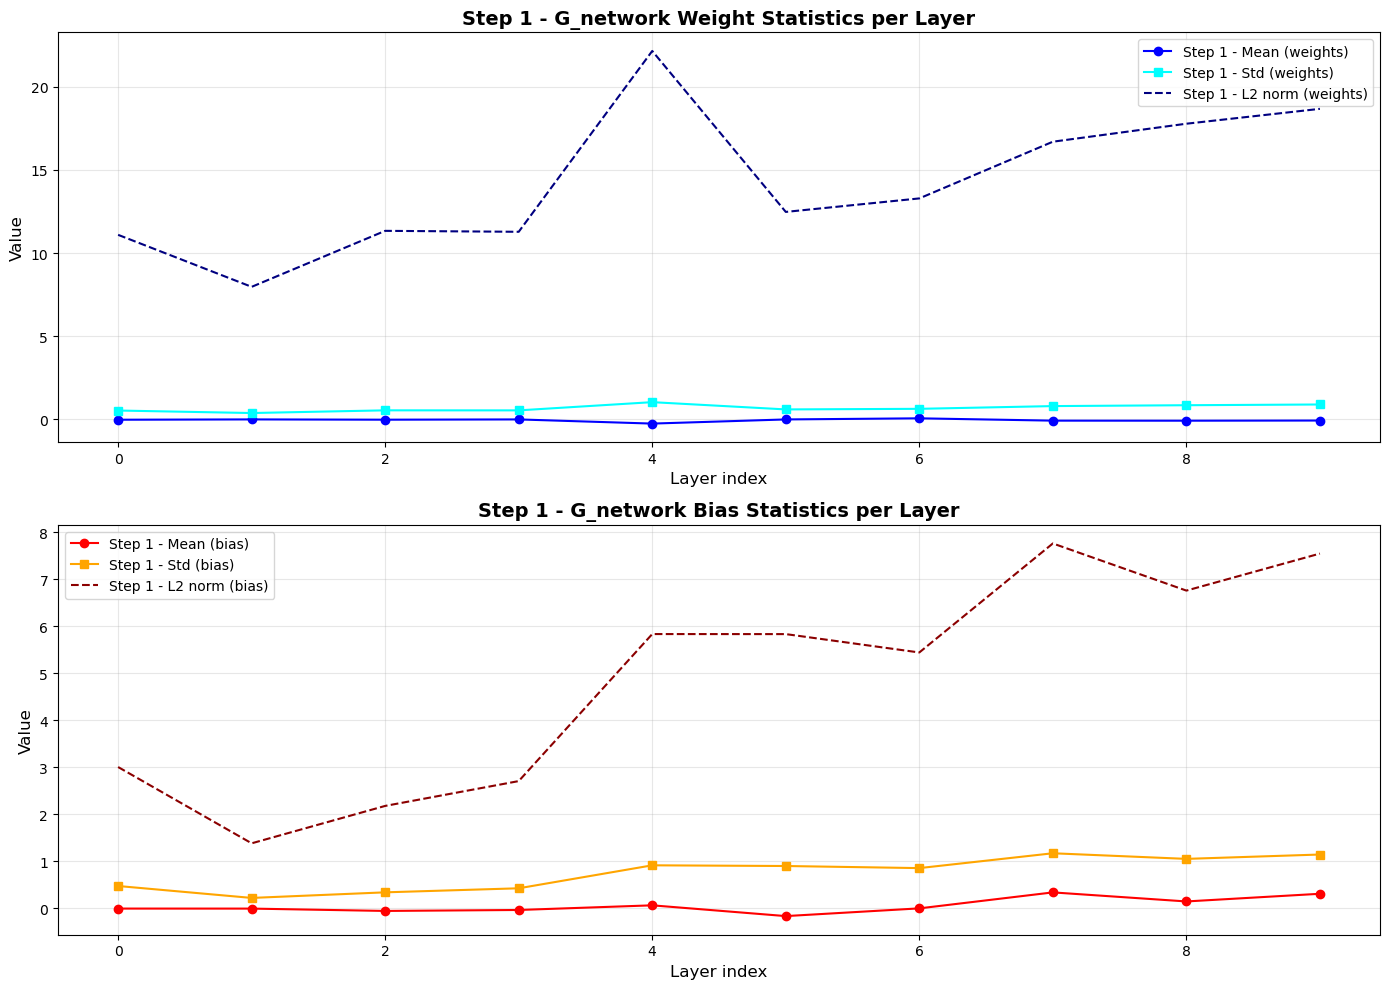

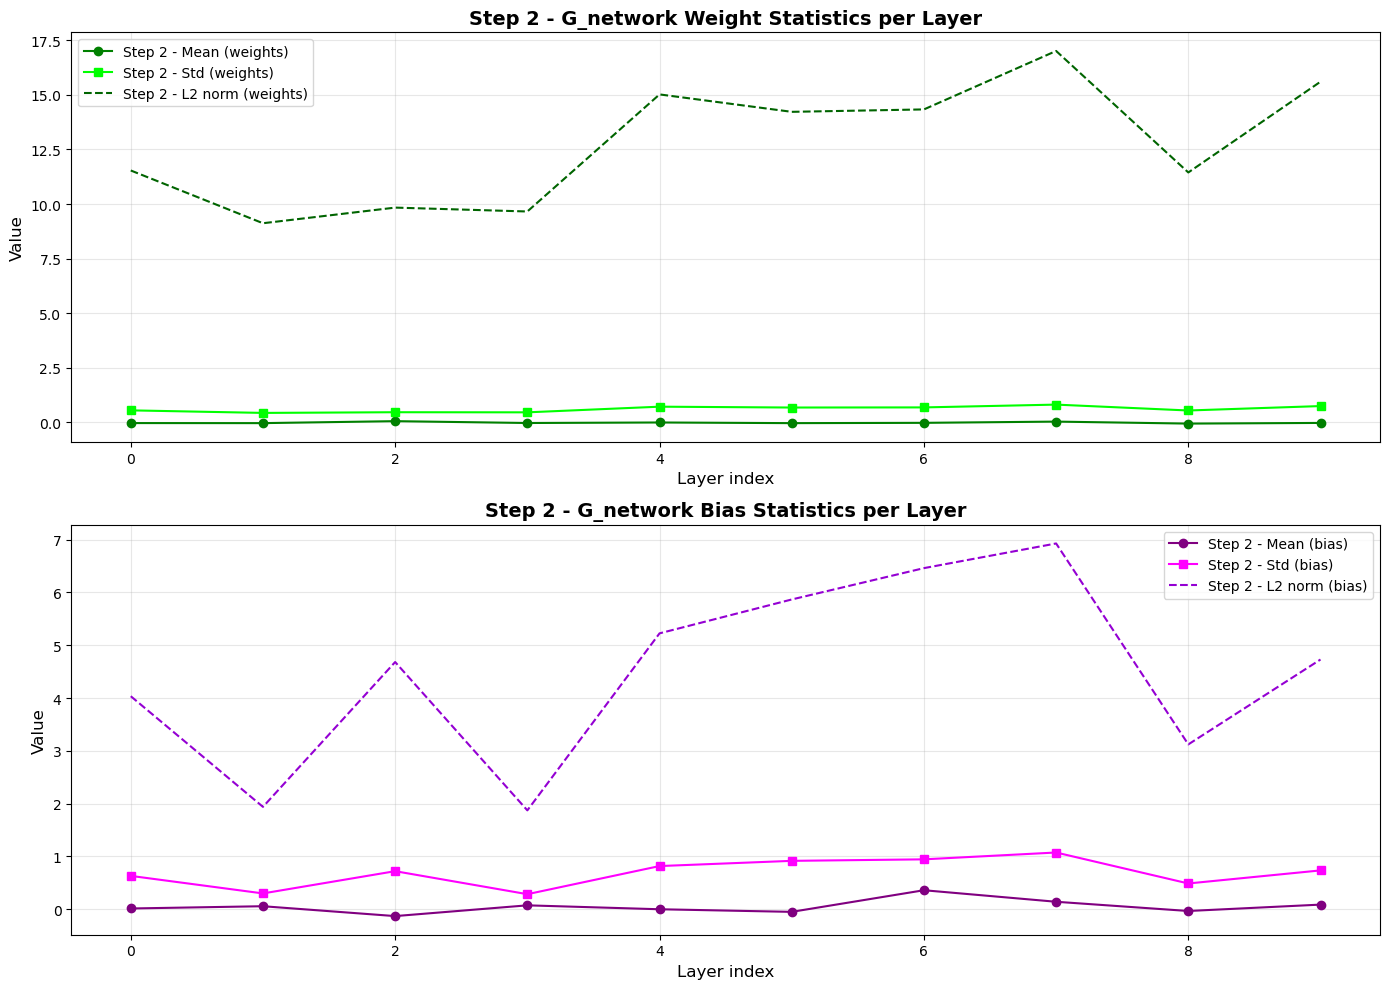

In [34]:
param_data = analyze_mapping_net(mapping_net, return_lists=True)


In [35]:
np.array(param_data['step_1_gamma_values']).mean()

np.float64(3.5735241889953615)

In [36]:
np.array(param_data['step_1_gamma_values']).std()

np.float64(1.978155649466863)

In [37]:
np.array(param_data['step_2_gamma_values']).mean()

np.float64(2.306011962890625)

In [38]:
np.array(param_data['step_2_gamma_values']).std()

np.float64(0.8855455134441416)

In [64]:
    mapping_net_test = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
        n_layers=15,
        # MLP Architecture parameters
        hidden_dims= [52],
        n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
        activation = 'gelu',
        activation_params = None,
        final_activation = None,   #Final layer activation function
        final_activation_only_on_final_layer = True,
        tanh_wrapper = False,
        
        # Initialization parameters
        weight_init = 'orthogonal',
        weight_init_params = {'gain': 1},
        bias_init = 'zeros',
        bias_init_value = 0.0,
        
        
        # Architectural choices
        use_bias = True,
        use_layer_norm = True,
        
        # Input/Output parameters
        input_dim = 2,  # x or u and t
        output_dim = 1,  # scalar G or F
        a_eps_min= 0.5,  # Minimum value for a
        a_eps_max= 2,  # Maximum value for a  
        a_k= 0.1,

        step_1_a_mean_innit= 1.0,
        step_2_a_mean_innit= 1.0,
        std_to_mean_ratio_a_mean_init= 0.3,

        step_1_gamma_mean_innit= 3.5,
        step_2_gamma_mean_innit= 2.5,
        std_to_mean_ratio_gamma_mean_init= 0.3,

        step_1_c1_mean_innit= 0.0,
        step_2_c1_mean_innit= 0.0,
        std_to_mean_ratio_c1_mean_init= 0.0,

        step_1_c2_mean_innit= 0.0,
        step_2_c2_mean_innit= 0.0,
        std_to_mean_ratio_c2_mean_init= 0.0,

        bound_innit=0.0,
    )
    

In [65]:
count_parameters(mapping_net_test)

9510

In [67]:
count_parameters(mapping_net_test)

15260